In [1]:
import pickle

import numpy as np
import pandas as pd
import tqdm

from datetime import date
from pathlib import Path

from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from scipy.sparse import vstack, hstack

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
%matplotlib inline

## 1. Прочитайте и проанализируйте данные

In [2]:
%%time


with open('players.pkl', 'rb') as f:
    players_data = pickle.load(f)
    
with open('results.pkl', 'rb') as f:
    results_data = pickle.load(f)
    
with open('tournaments.pkl', 'rb') as f:
    tournaments_data = pickle.load(f)

CPU times: user 12.6 s, sys: 1.27 s, total: 13.9 s
Wall time: 14 s


In [3]:
#Sanity check

for key, value in players_data.items():
    assert key == value['id'], (f'Ключ не равен id для игрока: (k, v)')
        
for key, value in tournaments_data.items():
    assert key == value['id'], (f'Ключ не равен id для турнира: (k, v)')

In [4]:
players = pd.DataFrame(players_data.values()).set_index('id', drop=True)
players.head()

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян


## Выделение train и test, предобработка данных

In [5]:
tournaments = pd.DataFrame(tournaments_data.values()).set_index('id', drop=True)
tournaments['dateStart'] = pd.to_datetime(tournaments['dateStart'], utc=True)
tournaments['dateEnd'] = pd.to_datetime(tournaments['dateEnd'], utc=True)

tournament_types = {}
for tournament in tournaments['type']:
    tournament_types[tournament['id']] =  tournament['name']

tournaments['type'] = tournaments['type'].apply(lambda x: x['id'])

tournaments.drop('orgcommittee', axis=1, inplace=True)
tournaments['year'] = tournaments.dateStart.dt.year
tournaments['month'] = tournaments.dateStart.dt.month
tournaments.head()

,name,dateStart,dateEnd,type,season,synchData,questionQty,year,month
id,,,,,,,,,
1,Чемпионат Южного Кавказа,2003-07-24 20:00:00+00:00,2003-07-26 20:00:00+00:00,2,/seasons/1,None,None,2003,7
2,Летние зори,2003-08-08 20:00:00+00:00,2003-08-08 20:00:00+00:00,2,/seasons/1,None,None,2003,8
3,Турнир в Ижевске,2003-11-21 21:00:00+00:00,2003-11-23 21:00:00+00:00,2,/seasons/2,None,None,2003,11
4,Чемпионат Украины. Переходной этап,2003-10-10 20:00:00+00:00,2003-10-11 20:00:00+00:00,2,/seasons/2,None,None,2003,10
5,Бостонское чаепитие,2003-10-09 20:00:00+00:00,2003-10-12 20:00:00+00:00,2,/seasons/2,None,None,2003,10


In [6]:
tournaments = tournaments[tournaments.year >= 2019]

# Добавим общее количество вопросов на турнире
tournaments['total_questions'] = tournaments.questionQty.apply(lambda x: sum((v for k, v in x.items())))
tournaments.head()

,name,dateStart,dateEnd,type,season,synchData,questionQty,year,month,total_questions
id,,,,,,,,,,
4628,Семь сорок,2020-12-30 13:00:00+00:00,2020-12-30 13:00:00+00:00,3,None,{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}",2020,12,36
4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,1,36
4957,Синхрон Биркиркары,2020-02-20 21:00:00+00:00,2020-02-27 20:00:00+00:00,3,/seasons/53,{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,"{'1': 13, '2': 13, '3': 13}",2020,2,39
4973,Балтийский Берег. 3 игра,2019-01-25 16:05:00+00:00,2019-01-29 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,1,36
4974,Балтийский Берег. 4 игра,2019-03-01 16:05:00+00:00,2019-03-05 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,3,36


In [7]:
train_tournaments = tournaments[tournaments.year == 2019]
test_tournaments = tournaments[tournaments.year == 2020]

print(f'Турниров в train: {len(train_tournaments)}')
print(f'Турниров в test: {len(test_tournaments)}')
print(f'Всего вопросов в train {train_tournaments.total_questions.sum()}')
print(f'Всего вопросов в test {test_tournaments.total_questions.sum()}')

Турниров в train: 689
Турниров в test: 416
Всего вопросов в train 34161
Всего вопросов в test 18135


In [8]:
def get_players_and_questions_qty(results_data, tournaments):
    players = set()
    for idx in tournaments.index:
        for team in results_data[idx]:
            team_id = team['team']['id']
            for player in team['teamMembers']:
                player_id = player['player']['id']
                players.add(player_id)
    return len(players), tournaments.total_questions.sum()

In [9]:
get_players_and_questions_qty(results_data, train_tournaments)

(59394, 34161)

## 2. Построение baseline-модели на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.

### Соберем список вопросов со сложностью и информацию об ответах игроков

In [10]:
%%time

questions_difficulty = []
players = []

for idx in train_tournaments.index:
    total_questions = train_tournaments.loc[idx].total_questions
    
    correct = np.zeros(total_questions, dtype=int)
    wrong = np.zeros(total_questions, dtype=int)
    canceled = np.zeros(total_questions, dtype=int)
    
    team_qty = len(results_data[idx])
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.array([1 if a=='X' else 0 for a in mask])
        mask = np.array([1 if a=='1' else 0 for a in mask])
        if len(mask) > total_questions:
            mask = mask[:total_questions]
        correct[:len(mask)] += mask
        wrong[:len(mask)] += (1 - mask)
        for player in team['teamMembers']:
            player_id = player['player']['id']
            for i, (pos, neg) in enumerate(zip(mask, 1 - mask)):
                if pos == 1:
                    players.append({'player_id': player_id, 'question': f'{idx}_{i}',
                                    'answered': 1, 'not_answered': 0})
                if neg == 1:
                    players.append({'player_id': player_id, 'question': f'{idx}_{i}',
                                    'answered': 0, 'not_answered': 1})
            

    for i, (pos, neg, cnl) in enumerate(zip(correct, wrong, canceled)):
        if np.all(pos == 0) and np.all(neg == 0):
            continue
        questions_difficulty.append({'id': f'{idx}_{i}',
                                     'tournament': idx, 'question': i,
                                     'canceled': cnl,
                                     'positive': pos, 'negative': neg,
                                     'difficulty': 1 - pos/(pos + neg)})
        
questions = pd.DataFrame(questions_difficulty)
questions.head()

CPU times: user 23.3 s, sys: 1.73 s, total: 25 s
Wall time: 25 s


,id,tournament,question,canceled,positive,negative,difficulty
0,4772_0,4772,0,0,204,27,0.116883
1,4772_1,4772,1,0,180,51,0.220779
2,4772_2,4772,2,0,103,128,0.554113
3,4772_3,4772,3,0,120,111,0.480519
4,4772_4,4772,4,0,203,28,0.121212


In [11]:
player_result = pd.DataFrame(players)
player_result.head()

,player_id,question,answered,not_answered
0,6212,4772_0,1,0
1,6212,4772_1,1,0
2,6212,4772_2,1,0
3,6212,4772_3,1,0
4,6212,4772_4,1,0


In [12]:
# Уберем из рассмотрения исключенные вопросы
questions = questions[questions.canceled==0]

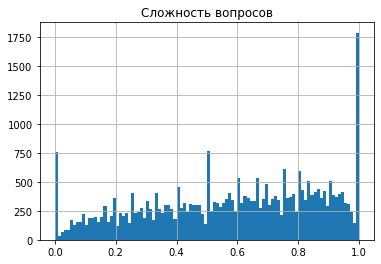

In [13]:
questions.difficulty.hist(bins=100)
plt.title('Сложность вопросов')
plt.show()

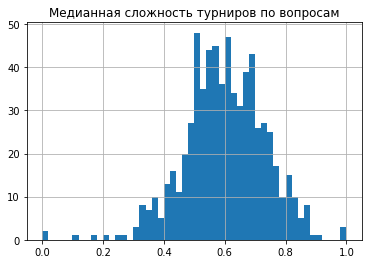

In [14]:
questions.groupby(['tournament']).agg({'difficulty': 'median'}).hist(bins=50)
plt.title('Медианная сложность турниров по вопросам')
plt.show()

### Разделим вопросы на n_levels уровней сложности и по ним будем строить предсказания рейтинга

In [15]:
n_levels = 5
quantiles = [questions.difficulty.quantile(i/n_levels) for i in range(1, n_levels + 1)]
questions['level'] = 0
for i in range(n_levels, 0, -1):
    questions.loc[questions.difficulty <= quantiles[i - 1], 'level'] = i

Для каждого игрока признаками будет:

1. количество вопросов каждой сложности, на которые он ответил правильно
2. количество вопросов каждой сложности, на котороые он не ответил правильно

In [16]:
player_result = pd.merge(player_result, questions, how='left', left_on='question', right_on='id')
player_result.head()

,player_id,question_x,answered,not_answered,id,tournament,question_y,canceled,positive,negative,difficulty,level
0,6212,4772_0,1,0,4772_0,4772.0,0.0,0.0,204.0,27.0,0.116883,1.0
1,6212,4772_1,1,0,4772_1,4772.0,1.0,0.0,180.0,51.0,0.220779,1.0
2,6212,4772_2,1,0,4772_2,4772.0,2.0,0.0,103.0,128.0,0.554113,3.0
3,6212,4772_3,1,0,4772_3,4772.0,3.0,0.0,120.0,111.0,0.480519,2.0
4,6212,4772_4,1,0,4772_4,4772.0,4.0,0.0,203.0,28.0,0.121212,1.0


In [17]:
player_result_grouped = player_result.groupby(['player_id', 'level']).agg({'answered': 'sum', 'not_answered': 'sum'})
player_result_grouped['p'] = player_result_grouped['answered'] / (player_result_grouped['answered'] + player_result_grouped['not_answered'])
player_result_grouped['n'] = player_result_grouped['answered'] + player_result_grouped['not_answered']
player_result_grouped = player_result_grouped[['n', 'p']].unstack(-1)
player_result_grouped

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
...          ...    ...    ...    ...    ...       ...       ...       ...   
224404      18.0   24.0   22.0   21.0   11.0  0.388889  0.416667  0.272727   
224408       2.0   10.0    8.0    4.0   12.0  0.500000  0.300000  0.000000   
224482       2.0   11.0    9.0   10.0    4.0  0.500000  0.181818  0.111111   
224539       6.0    8.0    9.0   11.0   11.0  0.666667  0.500000  0.333333   
224542      15.0    8.0    8.0    3.0    2.0  1.000000  0.875000  0.625000   

                               
level           4.0       5.0  
player_id                      
15         0.163793  0.054545  
16         0.189189  0.000000  
23         0.200000  0.000000  
31         0.270270  0.038760  
35         0.242857  0.103448  
...             ...       ...  
224404     0.238095  0.000000  
224408     0.000000  0.000000  
224482     0.000000  0.000000  
224539     0.090909  0.000000  
224542     0.000000  0.000000  

[59271 rows x 10 columns]

In [18]:
# Заполнение пропусков в данных
player_result_grouped['n'] = player_result_grouped['n'].fillna(0)
player_result_grouped['p'] = player_result_grouped['p'].fillna(player_result_grouped['p'].median())

In [19]:
median_p = {}
for i in range(1, n_levels + 1):
    median_p[i] = player_result_grouped.loc[:, ('p', i)].median()
    print(f"Median for difficulty {i}: {median_p[i]}")

Median for difficulty 1: 0.7857142857142857
Median for difficulty 2: 0.4876218776116631
Median for difficulty 3: 0.2777777777777778
Median for difficulty 4: 0.1276595744680851
Median for difficulty 5: 0.0


In [20]:
dfclty = 1
player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & (player_result_grouped[('n', dfclty)] < 5),
                          ('p', dfclty)] = player_result_grouped.loc[:, ('p', dfclty)].median()

In [21]:
for dfclty in range(2, n_levels):
# Здесь будем менять на вероятность более нижней сложности
    low_difficulty = player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                                               (player_result_grouped[('n', dfclty)] < 5),
                                               ('p', dfclty - 1)] < median_p[dfclty]
    low_difficulty = low_difficulty[low_difficulty]
    player_result_grouped.loc[low_difficulty.index,
                              ('p', dfclty)] = player_result_grouped.loc[low_difficulty.index,
                                                                             ('p', dfclty - 1)]
# Здесь будем менять на среднюю
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                              (player_result_grouped[('n', dfclty)] < 5),
                              ('p', dfclty)] = median_p[dfclty]

In [22]:
min_p = {}
for i in range(1, n_levels + 1):
    min_p[i] = player_result_grouped.loc[player_result_grouped[('p', i)] > 0, ('p', i)].min()
    print(f"Min for difficulty {i}: {min_p[i]}")

Min for difficulty 1: 0.043478260869565216
Min for difficulty 2: 0.018518518518518517
Min for difficulty 3: 0.011363636363636364
Min for difficulty 4: 0.0058823529411764705
Min for difficulty 5: 0.003389830508474576


In [23]:
for dfclty in range(1, n_levels):
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0),
                              ('p', dfclty)] = min_p[dfclty]

In [24]:
player_result_grouped['total_questions'] = player_result_grouped['n'].sum(axis=1)
player_result_grouped.head().append(player_result_grouped.tail())

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
224404      18.0   24.0   22.0   21.0   11.0  0.388889  0.416667  0.272727   
224408       2.0   10.0    8.0    4.0   12.0  0.500000  0.300000  0.011364   
224482       2.0   11.0    9.0   10.0    4.0  0.500000  0.181818  0.111111   
224539       6.0    8.0    9.0   11.0   11.0  0.666667  0.500000  0.333333   
224542      15.0    8.0    8.0    3.0    2.0  1.000000  0.875000  0.625000   

                              total_questions  
level           4.0       5.0                  
player_id                                      
15         0.163793  0.054545           560.0  
16         0.189189  0.000000           234.0  
23         0.200000  0.000000            36.0  
31         0.270270  0.038760           865.0  
35         0.242857  0.103448           779.0  
224404     0.238095  0.000000            96.0  
224408     0.127660  0.000000            36.0  
224482     0.005882  0.000000            36.0  
224539     0.090909  0.000000            45.0  
224542     0.127660  0.000000            36.0

### Признаки для игроков мы сгенерировали, добавим к ним сложность вопросов и обучим логистическую регрессию

In [25]:
dataset = player_result.drop(['id', 'tournament', 'question_x', 'not_answered',
                              'question_y', 'canceled', 'positive', 'negative', 'level'], axis=1)


In [26]:
dataset.index = dataset.player_id
dataset.drop('player_id', axis=1, inplace = True)
dataset.dropna(inplace=True)
dataset.head()

,answered,difficulty
player_id,,
6212,1,0.116883
6212,1,0.220779
6212,1,0.554113
6212,1,0.480519
6212,1,0.121212


In [27]:
dataset = dataset.merge(player_result_grouped.drop('total_questions', axis=1), how='left', left_index=True, right_index=True)
dataset.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,answered,difficulty,"(n, 1.0)","(n, 2.0)","(n, 3.0)","(n, 4.0)","(n, 5.0)","(p, 1.0)","(p, 2.0)","(p, 3.0)","(p, 4.0)","(p, 5.0)"
player_id,,,,,,,,,,,,
15,1,0.438169,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.196689,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.226874,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.460565,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.703019,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545


In [28]:
# Нормировка признаков
min_qty = []
max_qty = []
for i in range(1, n_levels + 1):
    min_qty.append(dataset[('n', i)].min())
    max_qty.append(dataset[('n', i)].max())
    dataset[('n', i)] = (dataset[('n', i)] - min_qty[-1]) / (max_qty[-1] - min_qty[-1])

In [29]:
dataset_sample = dataset.sample(5000000)
X = dataset_sample.drop('answered', axis=1).values
y = dataset_sample['answered'].values
print(X.shape)

(5000000, 11)


In [30]:
model = LogisticRegression(verbose=1)
model.fit(X, y)
pred = model.predict(X)
print(f'Accuracy: {np.sum(pred == y)/len(pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.7587848


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s finished


### Для каждого игрока теперь просэмплируем по 20000 вопросов разной сложности и посчитаем для каждого игрока на сколько из них он бы ответил - далее построим рейтинг

In [31]:
players_total_questions = player_result_grouped.total_questions.copy()
player_result_grouped.drop('total_questions', axis=1, inplace=True)
players_total_questions.head()

player_id
15    560.0
16    234.0
23     36.0
31    865.0
35    779.0
Name: total_questions, dtype: float64

In [32]:
# Из этого распределения будем сэмплировать вопросы:
p_questions = questions.difficulty

sample_size = 20000
q_sample = np.array(p_questions.sample(sample_size)).reshape(-1, 1)

In [33]:
# Проведем нормировку для количества вопросов
for i in range(1, n_levels + 1):
    player_result_grouped[('n', i)] = (player_result_grouped[('n', i)] - min_qty[-1]) / (max_qty[-1] - min_qty[-1])

In [34]:
players_rating = []
for idx in tqdm.tqdm(player_result_grouped.index):
    player_sample = np.array(player_result_grouped.loc[idx]).reshape(1, -1)
    X = np.hstack([q_sample, np.tile(player_sample, (sample_size, 1))])
    rating = model.predict(X).sum()
    players_rating.append({'id': idx, 'rating': rating})

100%|██████████| 59271/59271 [00:48<00:00, 1220.61it/s]


In [35]:
players_rating = pd.DataFrame(players_rating).sort_values('rating', ascending=False)

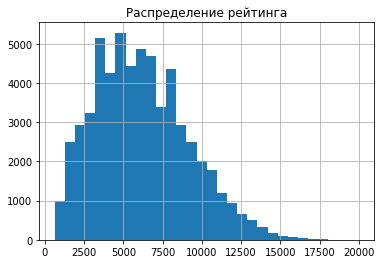

In [36]:
players_rating.rating.hist(bins=30)
plt.title('Распределение рейтинга')
plt.show()

In [37]:
players_names = pd.DataFrame([v for k, v in players_data.items()])
players_names.index = players_names.id
players_names.drop('id', axis=1, inplace=True)

players_rating.index = players_rating.id
players_rating.drop('id', axis=1, inplace=True)

players_rating = pd.merge(players_rating, players_names, how='left', left_index=True, right_index=True)
players_rating = pd.merge(players_rating, players_total_questions, how='left', left_index=True, right_index=True)

In [38]:
linear_rating = players_rating[players_rating.total_questions > 1000]
linear_rating.head(30)

,rating,name,patronymic,surname,total_questions
id,,,,,
27403,17095,Максим,Михайлович,Руссо,2331.0
28751,17028,Иван,Николаевич,Семушин,3963.0
4270,17024,Александра,Владимировна,Брутер,2881.0
27822,16619,Михаил,Владимирович,Савченков,3449.0
30152,16458,Артём,Сергеевич,Сорожкин,5083.0
30270,16373,Сергей,Леонидович,Спешков,3962.0
87637,15902,Антон,Владимирович,Саксонов,1266.0
56647,15505,Наталья,Евгеньевна,Горелова,2165.0
20691,15498,Станислав,Григорьевич,Мереминский,1656.0


Почти все эти игроки находятся высоко в рейтинге на сайте https://rating.chgk.info

# 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров.

In [39]:
class Tournament:
    def __init__(self, 
                 idx, 
                 results=results_data,
                 tournaments=test_tournaments,
                 model=model, p_questions=p_questions, 
                 players_features=player_result_grouped):
        self.idx = idx
        self.results = results[idx]
        self.model = model
        self.players_features = players_features
        
        self.total_questions = tournaments.loc[idx, 'total_questions']
        self.teams = self._load_teams()
        self.questions = np.array(p_questions.sample(self.total_questions)).reshape(-1, 1)
        
    def _load_teams(self):
        teams = []
        for team in self.results:
            if 'position' not in team or team['mask'] is None:
                continue
            current_team = {}
            current_team['name'] = team['team']['name']
            current_team['position'] = team['position']
            current_team['members'] = self._load_team_members(team)
            teams.append(current_team)
        return teams
        
    def _load_team_members(self, team):
        players = {}
        for player in team['teamMembers']:
            player_id = player['player']['id']
            if player_id not in player_result_grouped.index:
                continue
            player_features = np.array(player_result_grouped.loc[player_id]).reshape(1, -1)
            players[player_id] = player_features
        return players
        
    def simulate(self):
        if len(self.teams) == 0:
            return None, None
        predicted_results = []
        factual_results = []
        for team in self.teams:
            prediction = self._simulate_team_result(team)
            if prediction == 0:
                continue
            factual_results.append(team['position'])
            predicted_results.append(prediction)
        return predicted_results, factual_results
    
    def _simulate_team_result(self, team):
        team_size = len(team['members'])
        if team_size == 0:
            return 0
        team_features = np.vstack([v for k, v in team['members'].items()])
        result = 0
        for q in self.questions:
            full = np.hstack([np.tile(q, (team_size, 1)), team_features])
            probs = model.predict_proba(full)[:,1]
            result += np.mean(probs)
        return -result
    
example_tournament = Tournament(5477)
prediction, ground_true = example_tournament.simulate()

In [40]:
spearman_correlations = []
kendall_correlations = []
for idx in tqdm.tqdm(test_tournaments.index):
    if results_data[idx]:
        tournament = Tournament(idx)
        prediction, ground_true = tournament.simulate()
        if prediction is None or ground_true is None:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)

100%|██████████| 416/416 [01:27<00:00,  4.73it/s]


In [41]:
print(f'Корреляция Спирмена: {np.mean([t for t in spearman_correlations if np.isfinite(t)]):0.2f}')
print(f'Корреляция Кендалла: {np.mean([t for t in kendall_correlations if np.isfinite(t)]):0.2f}')

Корреляция Спирмена: 0.71
Корреляция Кендалла: 0.55


Значения попали в ожидаемые интервалы

# 4. Теперь главное: ЧГК — это всё-таки командная игра. EM-схема

In [42]:
total_players, total_questions = get_players_and_questions_qty(results_data, train_tournaments)
print(f'В train всего {total_players} игроков')
print(f'В train всего {total_questions} вопросов')

В train всего 59394 игроков
В train всего 34161 вопросов


Модель для ответов на вопрос каждого игрока

* Ранее мы генерировали для каждого игрока несколько признаков, исходя из его ответов на вопросы разной сложности. Теперь мы  оставим ровно 1 признак для каждого игрока - это и будет его скилл - $p_{i}$. Каждый вопрос будет характеризоваться сложностью $q_{j}$.

* Ответил игрок i на вопрос j - это задача бинарной классификации, т.е. будем использовать как и в бейзлайне логистическую регрессию, но теперь без дополнительных признаков - на вход подаем 2 объединенных OHE вектора - номер игрока и номер вопроса (59394 + 34161), на выходе 1 или 0. 

Применение EM алгоритма

* Мы не можем зафиксировать команды, т.к. игрок может переходить в разные команды от турнира к турниру, поэтому далее объект "команда" - это вектор из 0 и 1 размера 59394, в котором 1 означает, что игрок входит в команду, а 0 - не входит.

* Мы наблюдаем ответ команды в целом на вопрос, пусть $x_{ti} = 1$ означает что команда $t$ ответила на вопрос $q$, и $x_{ti} = 0$ означает что команда $t$ не ответила на вопрос $i$

* Мы моделируем ответ игрока $i$ на вопрос $j$ как $\sigma(p_{i} + q_{j} + const)$

* Обозначим скрытые переменные $z_{ij}$ - ответ игрока $i$ на вопрос $j$ - мы не знаем как отвечал конкретный игрок внутри команды, но можем попробовать связать их $z_{ij}$ с $x_{tj}$ - ответом команды на копрос $j$:

1. Если команда $t$ не ответила на вопрос $i$, то считаем, что ни один из игроков не ответил на вопрос (случай, когда кто-то знал правильный ответ, но команда выбрала другой ответ - не рассматриваем), т.е. $z_{ij} = 0 \forall j \in t$
2. Если команда $t$ ответила на вопрос $i$, то считаем, что как существует как минимум 1 игрок из этой команды, который знал правильный ответ: $\exists j \in t: z_{ij} = 1$

EM-схема будет выглядеть следующим образом:

* Обучим логистические регрессии $x_{tj} \sim \sigma(p_{i} + q_{j} + const) \forall i \in t$ и найдем начальные значения $p_{i}$ и $q_{j}$

* __E-шаг__ - найдем мат. ожидания $z_{i}{j}$: $\mathbf{E}z_{ij} = 
\begin{cases}
0, \forall i \in t, \text{если команда t не ответила на вопрос j}\\
\frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \in t}(1 - \sigma(p_{k} + q_{j} + const))}, \text{если команда t ответила на вопрос j - далее покажу как пришел к этому}\\
\end{cases}$

* __M-шаг__ - с новыми $\mathbf{E}z_{ij}$ обновляем $p_{i}$ и $q_{j}$, то есть находим оптимальные значения для задачи: $\mathbf{E}z_{ij} \sim \sigma(p_{i} + q_{j} + const)$

### Вывод E-шага

Если команда ответила на вопрос правильно, то хотя бы один игрок смог ответить правильно. Пусть у нас в команде $m$ игроков и событие, что они дали правильный ответ на текущий вопрос с текущими $p_{i}$ и $q_{j}$ - $A_{i} \forall i \leqslant m$

$p(A_{i}) = \sigma(p_{i} + q_{j} + const) \forall i \leqslant m$

Событие $B$ - это команда ответила правильно, вероятность этого события $P(B) = 1 - \prod_{i \leqslant m}(1 - p(A_i))$ - то есть вероятность того, что хотя бы один из игроков дал правильный ответ.

В E-шаге нам нужно вычислить $\mathbf{E}(z_{ij})$ то есть мат ожидание вероятности того, что игрок ответил правильно, при условии, что команда ответила правильно, то есть: $P(z_{ij}|x_{tj})$

Применим теорему Байеса:

$P(z_{ij}|x_{tj}=1) = P(A_i|B) = \frac{P(B|A_i)P(A_i)}{P(B)} = $

учтем, что вероятность $P(B|A_i)=1$ т.к. если игрок дал правильный ответ, то и команда дала правильный ответ

$= \frac{P(A_i)}{P(B)} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - p(A_k))} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - \sigma(p_{k} + q_{j} + const))}$

In [43]:
player_ids = set()
train_questions_qty = 0

for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
        for player in team['teamMembers']:
            player_ids.add(player['player']['id'])

    train_questions_qty += (tournament_questions - canceled)
    
player_ids = np.array(list(player_ids)).reshape(-1, 1)
print(f'Всего игроков: {(player_ids.shape[0])}')
print(f'Всего вопросов: {train_questions_qty} - исключили вопросы, которые были отменены/сняты')

100%|██████████| 689/689 [00:01<00:00, 523.00it/s]

Всего игроков: 59271
Всего вопросов: 34078 - исключили вопросы, которые были отменены/сняты


In [44]:
total_players = player_ids.shape[0]
total_questions = train_questions_qty

In [45]:
ohe_players = OneHotEncoder()
ohe_players.fit(player_ids)

ohe_questions = OneHotEncoder()
ohe_questions.fit(np.arange(train_questions_qty).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [46]:
target = []
data = []
total_pairs = 0

tournament_first_question_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    if len(results_data[idx]) == 0:
        continue
    tournament_questions = train_tournaments.loc[idx].total_questions
    team_data = []
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        
        # Убираем снятые вопросы (отмеченные 'Х')
        mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])
        
        team_size = len(team['teamMembers'])
        questions_qty = mask.shape[0]
        
        if team_size == 0:
            continue
            
        players = np.array([np.full((questions_qty, ), player['player']['id'])
                                for player in team['teamMembers']]).reshape(-1, 1)
        players_matrix = ohe_players.transform(players)
        
        questions_list = np.tile(
            np.arange(tournament_first_question_idx,
                      tournament_first_question_idx + questions_qty
                     ),
            team_size
        ).reshape(-1, 1)
        questions_matrix = ohe_questions.transform(questions_list)
        
        # Результаты ответов
        target.extend(np.tile(mask, team_size))
        
        team_data.append(hstack([players_matrix,
                                 questions_matrix]))
    tournament_first_question_idx += questions_qty
    if len(team_data) > 0:
        data.append(vstack(team_data))

X = vstack(data)
y = np.array(target)

100%|██████████| 689/689 [02:10<00:00,  5.27it/s]


In [47]:
%%time

baseline_2 = LogisticRegression(verbose=1, solver='saga')
baseline_2.fit(X, y)
pred = baseline_2.predict(X)
print(f'Accuracy: {np.sum(pred == y)/len(pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 412 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished


Accuracy: 0.7555412229133888
CPU times: user 6min 48s, sys: 3.15 s, total: 6min 52s
Wall time: 6min 54s


In [48]:
def calculate_metrics(model, tournaments=test_tournaments, result=results_data,
                        ohe_players=ohe_players,
                        ohe_questions=ohe_questions,
                        average_q=0):
    spearman_correlations = []
    kendall_correlations = []
    for i, idx in enumerate(tqdm.tqdm(tournaments.index)):
        prediction, ground_true = [], []
        for team in result[idx]:
            # Если по команде нет результата - то пропускаем
            if 'position' not in team:
                continue
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue
    
            team_size = len(team['teamMembers'])
            # Если в команде нет игроков - пропускаем
            if team_size == 0:
                continue
            team_members = []
            for player in team['teamMembers']:
                # Пропускаем новых игроков, которых не было в train
                try:
                    ohe_players.transform([[player['player']['id']]])
                    team_members.append(player['player']['id'])
                except ValueError:
                    continue
            team_size = len(team_members)
            if team_size == 0:
                continue
                
            ground_true.append(team['position'])
            players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
            question_matrix = ohe_questions.transform(np.full((team_size, 1), average_q))
            X = hstack([players_matrix, question_matrix])
            skill = model.predict_proba(X)[:, 1]
            team_rating = 1 - np.prod(1 - skill)
            prediction.append(-team_rating)
        if np.unique(ground_true).shape[0] == 1:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)
            
    spearman_corr = np.mean([t for t in spearman_correlations if np.isfinite(t)])
    kendall_corr = np.mean([t for t in kendall_correlations if np.isfinite(t)])
    return spearman_corr, kendall_corr

In [49]:
spearman_baseline_2, kendall_base_line_2 = calculate_metrics(baseline_2)
print(f'Корреляция Спирмена: {spearman_baseline_2:0.2f}')
print(f'Корреляция Кендалла: {kendall_base_line_2:0.2f}')

100%|██████████| 416/416 [01:31<00:00,  4.56it/s]

Корреляция Спирмена: 0.74
Корреляция Кендалла: 0.58


на подготовкительно шагу результат уже __лучше__, чем у бейзлайна

In [50]:
from scipy.sparse import csc_matrix

def E_step(model, train_data=X,
           y = y,
           tournaments=train_tournaments,
           result=results_data,
           num_players=total_players,
           num_questions=total_questions):
    
    predictions = model.predict_proba(train_data)[:, 1]
    z = np.zeros(predictions.shape)   
    tournament_first_question_idx = 0
    current_idx = 0
    
    for idx in tqdm.tqdm(tournaments.index):
        if len(result[idx]) == 0:
            continue
        tournament_questions = tournaments.loc[idx].total_questions
        team_data = []
        for team in result[idx]:
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue

            # Убираем снятые вопросы (отмеченные 'Х')
            mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])

            team_size = len(team['teamMembers'])
            questions_qty = mask.shape[0]
            batch_size = team_size * questions_qty

            if team_size == 0:
                continue

            team_answers = predictions[current_idx: current_idx + batch_size]
            true_team_answers = y[current_idx: current_idx + questions_qty]
            
            team_answers = team_answers.reshape((-1, questions_qty)).T
            denominator = 1 - np.prod(1 - team_answers, axis=1)
            team_answers = team_answers / denominator.reshape(-1, 1)
            
            team_answers[true_team_answers==0, :] = 0
            
            predictions[current_idx: current_idx + batch_size] = team_answers.T.reshape(-1) 
            current_idx += batch_size
    return predictions

In [51]:
def log_loss(pred, target, weights=None):
    if weights is not None:
        return np.average(-target * np.log(pred) - (1 - target) * np.log(1 - pred), weights=weights)
    return np.mean(-target * np.log(pred) - (1 - target) * np.log(1 - pred))

In [52]:
def M_step(z, train_data=X):
    y_0 = np.zeros((train_data.shape[0], 1))
    y_1 = np.ones((train_data.shape[0], 1))
    y = np.vstack([y_0, y_1]).reshape(-1)
    train_data = vstack([train_data, train_data])
    weights = np.concatenate([1 - z, z])
    model = LogisticRegression(verbose=1, solver='saga')
    model.fit(train_data, y, sample_weight=weights)
    proba = model.predict_proba(train_data)[:, 1]
    return model, log_loss(proba, y, weights)

In [53]:
spearman_train, kendall_train = calculate_metrics(baseline_2, tournaments=train_tournaments)
spearman_test, kendall_test = calculate_metrics(baseline_2)
print('Baseline #2')
print(f'Корреляция Спирмена - train: {spearman_train:0.4f}')
print(f'Корреляция Кендалла - train: {kendall_train:0.4f}')
print(f'Корреляция Спирмена - test: {spearman_test:0.4f}')
print(f'Корреляция Кендалла - test: {kendall_test:0.4f}')

100%|██████████| 416/416 [01:36<00:00,  4.31it/s]

Baseline #2
Корреляция Спирмена - train: 0.7845
Корреляция Кендалла - train: 0.6294
Корреляция Спирмена - test: 0.7378
Корреляция Кендалла - test: 0.5812


In [54]:
ITERS = 5

In [55]:
spearman_train = [spearman_train]
spearman_test = [spearman_test]
kendall_train = [kendall_train]
kendall_test = [kendall_test]

best_metrics = np.mean([spearman_test, kendall_test])
best_em_model = baseline_2

model_m = baseline_2
for i in range(ITERS):
    z = E_step(model=model_m)
    model_m, loss = M_step(z)
    
    spearman_corr_train, kendall_corr_train = calculate_metrics(model_m, tournaments=train_tournaments)
    spearman_corr_test, kendall_corr_test = calculate_metrics(model_m)
    spearman_train.append(spearman_corr_train)
    spearman_test.append(spearman_corr_test)
    kendall_train.append(kendall_corr_train)
    kendall_test.append(kendall_corr_test)
    
    print(f'После итерации {i + 1}')
    print(f'Корреляция Спирмена - train: {spearman_corr_train:0.4f}')
    print(f'Корреляция Кендалла - train: {kendall_corr_train:0.4f}')
    print(f'Корреляция Спирмена - test: {spearman_corr_test:0.4f}')
    print(f'Корреляция Кендалла - test: {kendall_corr_test:0.4f}')
    print(f'Log loss: {loss:0.4f}')
    
    if np.mean([spearman_corr_test, kendall_corr_test]) > best_metrics:
        best_em_model = model_m
        best_metrics = np.mean([spearman_corr_test, kendall_corr_test])

100%|██████████| 689/689 [00:02<00:00, 251.19it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 872 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.6min finished
100%|██████████| 416/416 [01:22<00:00,  5.04it/s]


После итерации 1
Корреляция Спирмена - train: 0.8183
Корреляция Кендалла - train: 0.6650
Корреляция Спирмена - test: 0.7740
Корреляция Кендалла - test: 0.6168
Log loss: 0.3931


100%|██████████| 689/689 [00:02<00:00, 243.29it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 872 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.6min finished
100%|██████████| 416/416 [01:21<00:00,  5.13it/s]


После итерации 2
Корреляция Спирмена - train: 0.8303
Корреляция Кендалла - train: 0.6789
Корреляция Спирмена - test: 0.7897
Корреляция Кендалла - test: 0.6307
Log loss: 0.3470


100%|██████████| 689/689 [00:02<00:00, 272.04it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 955 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.9min finished
100%|██████████| 416/416 [01:21<00:00,  5.12it/s]


После итерации 3
Корреляция Спирмена - train: 0.8366
Корреляция Кендалла - train: 0.6857
Корреляция Спирмена - test: 0.7926
Корреляция Кендалла - test: 0.6341
Log loss: 0.3285


100%|██████████| 689/689 [00:02<00:00, 275.16it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 5341 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 89.0min finished
100%|██████████| 416/416 [01:25<00:00,  4.84it/s]


После итерации 4
Корреляция Спирмена - train: 0.8425
Корреляция Кендалла - train: 0.6929
Корреляция Спирмена - test: 0.7931
Корреляция Кендалла - test: 0.6346
Log loss: 0.3203


100%|██████████| 689/689 [00:02<00:00, 281.40it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 915 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.3min finished
100%|██████████| 416/416 [01:22<00:00,  5.03it/s]

После итерации 5
Корреляция Спирмена - train: 0.8470
Корреляция Кендалла - train: 0.6985
Корреляция Спирмена - test: 0.7923
Корреляция Кендалла - test: 0.6344
Log loss: 0.3160


In [56]:
spearman_train

[0.7844921114267455,
 0.8183171612484671,
 0.8303277332123717,
 0.8365916196456251,
 0.8425441799819272,
 0.8469623359351456]

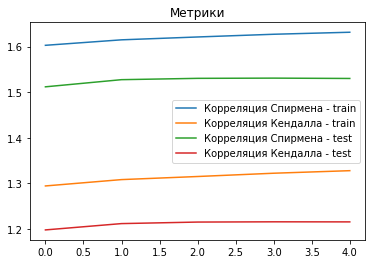

In [57]:
plt.plot(spearman_train[0] + spearman_train[1:], label='Корреляция Спирмена - train')
plt.plot(kendall_train[0] + kendall_train[1:], label='Корреляция Кендалла - train')
plt.plot(spearman_test[0] + spearman_test[1:], label='Корреляция Спирмена - test')
plt.plot(kendall_test[0] + kendall_test[1:], label='Корреляция Кендалла - test')
plt.legend()
plt.title('Метрики')
plt.show()

В дальнейшем будем использовать лучшую модель 

In [58]:
pickle.dump(best_em_model, open('best_em_model.sav', 'wb'))
pickle.dump(ohe_players, open('players.sav', 'wb'))
pickle.dump(ohe_questions, open('questions.sav', 'wb'))

In [59]:
best_em_model = pickle.load(open('best_em_model.sav', 'rb'))
ohe_players = pickle.load(open('players.sav', 'rb'))
ohe_questions = pickle.load(open('questions.sav', 'rb'))

# 5. А что там с вопросами?

In [60]:
p = best_em_model.coef_[0][:total_players] # "скилл" игрока
q = best_em_model.coef_[0][total_players:] # "сложность" вопроса

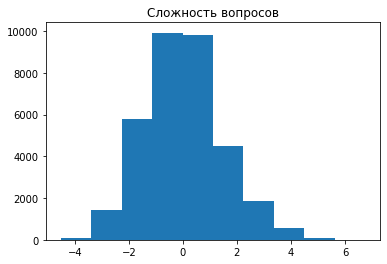

Средняя сложность вопроса: -0.0


In [61]:
plt.hist(q)
plt.title('Сложность вопросов')
plt.show()
print(f'Средняя сложность вопроса: {round(np.mean(q), 3)}')

In [62]:
tournaments_questions = {}
current_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
    tournaments_questions[idx] = q[current_idx:current_idx + (tournament_questions - canceled)]
    current_idx += (tournament_questions - canceled)

100%|██████████| 689/689 [00:00<00:00, 692.74it/s]


In [63]:
average_difficulty = {k: np.mean(v) for k, v in tournaments_questions.items()}
sorted_tournaments = sorted([(k, v) for k, v in average_difficulty.items()], key= lambda x: x[1])

In [64]:
# Турниры с самыми сложными вопросами:

for i, (k, v) in enumerate(sorted_tournaments[:10]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5159-Первенство правого полушария - -1.813
2. 5464-Зимние игры - -1.658
3. 5025-Кубок городов - -1.623
4. 5083-Ускользающая сова - -1.441
5. 5887-Я.Сова - -1.436
6. 5905-Синхрон Беловежской Зимы. День второй. - -1.432
7. 5794-Блаженный Августинер - -1.407
8. 5815-Гусарская лига. III сезон. II этап - -1.407
9. 5186-VERSUS: Коробейников vs. Матвеев - -1.352
10. 5098-Ра-II: синхрон "Борского корабела" - -1.348


In [65]:
# Турниры с самыми простыми вопросами:

for i, (k, v) in enumerate(sorted_tournaments[:-10:-1]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5807-Лига Сибири. II тур. - 2.193
2. 5013-(а)Синхрон-lite. Лига старта. Эпизод V - 2.127
3. 5438-Синхрон Лиги Разума - 2.112
4. 5795-Кубок Москвы - 2.102
5. 5797-Третья октава - 1.993
6. 5009-(а)Синхрон-lite. Лига старта. Эпизод III - 1.964
7. 5817-Симбирск-Open - 1.932
8. 5979-ТРИОтлон-4 - 1.853
9. 5704-(а)Синхрон-lite. Лига старта. Эпизод X - 1.840
